In [ ]:
# 4 agents: renewable, gas exit, gas entry, coal exit

In [2]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import linprog
import matplotlib
import matplotlib.pyplot as plt
import time
from cvxopt import solvers, matrix, sparse
from scipy.optimize import root_scalar
from scipy.sparse import bsr_matrix
from scipy.stats import gamma
from scipy.stats import beta
from scipy.linalg import block_diag
import random

In [3]:
# interval
Smin = 0.1
Smax = 0.7
Cmin = 0
Cmax = 120
tmin = 0
tmax = 30

# number for points
NS = 41
NC = 41
Nt = 101

# discretization
dS = 1.*(Smax-Smin)/(NS-1)
dC = 1.*(Cmax-Cmin)/(NC-1)
dt = 1.*(tmax-tmin)/(Nt-1)

# define grid in space
S = np.linspace(Smin,Smax,NS)
C = np.linspace(Cmin,Cmax,NC)
T = np.linspace(tmin,tmax,Nt)

# long-term average cost
theta_G = 37.94
theta_C = 22.5
theta_R = 0.4

# standard deviation
std_G = 12.53
std_C = 10
std_R = 0.075

# rate of mean reversion
kG = 0.5
kC = 0.5
kR = 0.5

# variability of the cost process 
delta_G = std_G*np.sqrt(2.*kG/theta_G)
delta_C = std_C*np.sqrt(2.*kC/theta_C)
delta_R = std_R*np.sqrt(2.*kR/(theta_R*(1-theta_R)-std_R*std_R))

rho = 0.08

epsilon = 0.5

# depreciation rate
gamma_G = np.log(2.)/15.
gamma_C = np.log(2.)/20.
gamma_R = np.log(2.)/12.5

# conversion of hourly revenue per MW into annual revenue per kW
convcoef = 24.*365.25/1000. 

# maximal price 
P = 150.

K_R = 1500. # per kW of installed capacity (who enter - fixing cost of owning the plant)
K_G_enter = 1450 # per kW of installed capacity (who enter - fixing cost of owning the plant)
K_G = 0 # per kW of installed capacity (who exit - value recovered if the plant is sold)
K_C = 0 # per kW of installed capacity (who exit - value recovered if the plant is sold)

# fixed cost
k_G = 32. # per kW per year
k_C = 58. # per kW per year
k_R = 30. # per kW per year

# coef carbon emission (tCO2/kWh)
ctax_G = 0.429
ctax_C = 0.986

# initial condition gas producers who exit
alpha_G = (theta_G/std_G)*(theta_G/std_G)
beta_G = theta_G/std_G/std_G
InitialOmega = 32*beta_G*gamma.pdf(beta_G*C,alpha_G)
# initial condition gas producers who enter
InitialLambda = 36.*beta_G*gamma.pdf(beta_G*C,alpha_G)
BarLambda = 36.*beta_G*gamma.pdf(beta_G*C,alpha_G)

# initial condition coal producers who exit
alpha_C = (theta_C/std_C)*(theta_C/std_C)
beta_C = theta_C/std_C/std_C
InitialMu = 44.9*beta_C*gamma.pdf(beta_C*C,alpha_C)

# initial condition renewable producers
alpha_R = theta_R*(theta_R*(1.-theta_R)/std_R/std_R-1.)
beta_R = (1.-theta_R)*(theta_R*(1.-theta_R)/std_R/std_R-1.)
BarEta = 118.3*beta.pdf(S,alpha_R,beta_R)
InitialEta = 64.*beta.pdf(S,alpha_R,beta_R)

# demand
demand = np.array([58.17932923,58.17932923,58.17932923,58.17932923
                    ,58.00821355,58.00821355,58.00821355,58.00821355
                    ,57.3709788,57.3709788,57.3709788,57.3709788
                    ,57.6659822,57.6659822,57.6659822,57.6659822
                    ,57.49486653,57.49486653,57.49486653,57.49486653
                    ,57.32375086,57.32375086,57.32375086,57.32375086
                    ,57.15263518,57.15263518,57.15263518,57.15263518
                    ,56.98151951,56.98151951,56.98151951,56.98151951
                    ,56.81040383,56.81040383,56.81040383,56.81040383
                    ,56.63928816,56.63928816,56.63928816,56.63928816
                    ,56.46817248,56.46817248,56.46817248,56.46817248
                    ,56.39972621,56.39972621,56.39972621,56.39972621
                    ,56.33127995,56.33127995,56.33127995,56.33127995
                    ,56.26283368,56.26283368,56.26283368,56.26283368
                    ,56.19438741,56.19438741,56.19438741,56.19438741
                    ,56.12594114,56.12594114,56.12594114,56.12594114
                    ,56.05749487,56.05749487,56.05749487,56.05749487
                    ,55.9890486,55.9890486,55.9890486,55.9890486
                    ,55.92060233,55.92060233,55.92060233,55.92060233
                    ,55.85215606,55.85215606,55.85215606,55.85215606
                    ,55.78370979,55.78370979,55.78370979,55.78370979
                    ,55.86356377,55.86356377,55.86356377,55.86356377
                    ,55.94341775,55.94341775,55.94341775,55.94341775
                    ,56.02327173,56.02327173,56.02327173,56.02327173
                    ,56.10312571,56.10312571,56.10312571,56.10312571
                    ,56.18297969,56.18297969,56.18297969,56.18297969
                    ,56.26283368,56.26283368,56.26283368,56.26283368
                    ,56.34268766,56.34268766,56.34268766,56.34268766
                    ,56.42254164,56.42254164,56.42254164,56.42254164
                    ,56.50239562,56.50239562,56.50239562,56.50239562
                    ,56.5822496,56.5822496,56.5822496,56.5822496])

# Adjusting for seasonal cycle
sc = np.array([[1.052491152, 0.962461095, 0.953705412, 1.037144059]])

sc = np.repeat(sc,len(demand)/4,axis=0)
sc = np.reshape(sc,1*len(demand))
demand[:101] = demand[:101]*sc[:101]
demand[100] = demand[100]*sc[0]

# peak / offpeak demand ratio
Dc = 1.257580634655325

# peak hours
pcoef = 65./168
# off-peak hours
opcoef = 1.-pcoef

# peak demand
pdemand = demand*Dc/(pcoef*Dc+opcoef)
# off-peak demand
opdemand = demand/(pcoef*Dc+opcoef)

# fonction G in the definition of the reward function for exit
def G(x):
    return (epsilon/2+(x-epsilon))*(x>epsilon)+x*x/2/epsilon*(x>0)*(x<=epsilon)

def F(x):
    return (x-epsilon>0)+x/epsilon*(x>0)*(x<=epsilon)

# baseline supply
def F0(X):
    return 17.5*X/150.

# fonction ptax - price carbon tax
def ptax(t):
    return 5.*t-10050 

# fonction g - payoff exit gas player
def g(x,p,t):
    return convcoef*G(p-x) - ctax_G*ptax(2020+t)*F(p-x) - k_G - (rho+gamma_G)*K_G*np.exp(-gamma_G*t)

# function h - payoff entry gas player
def h(x,p,t):
    return -convcoef*G(p-x) + ctax_G*ptax(2020+t)*F(p-x) + k_G + rho*K_G_enter + gamma_G*K_G_enter*np.exp(-(rho+gamma_G)*(tmax-t))

# fonction f - payoff entry renewable player
def f(x,p,t):
    return -convcoef*p*x + k_R + rho*K_R + gamma_R*K_R*np.exp(-(rho+gamma_R)*(tmax-t))

# fonction l - payoff exit coal player
def l(x,p,t):
    return convcoef*G(p-x) - ctax_C*ptax(2020+t)*F(p-x) - k_C - (rho+gamma_C)*K_C*np.exp(-gamma_C*t)

# residual demand
def computeR(eta,dem):
    maxdem = sum(S[:-1]*BarEta[0:NS-1])*dS
    Eta = np.reshape(eta,(Nt,NS))
    R = dem[:Nt]+np.matmul(Eta,S)*dS-maxdem
    return (R[:Nt]*(R[:Nt]>0))

# total supply by the conventional gas producers at prive level p
def computeM(l, p):
    maxdem = sum(F(p-C[:-1])*BarLambda[0:NC-1])*dC
    Lamb = np.reshape(l,(Nt,NS))
    M = maxdem - np.matmul(Lamb,F(p-C))*dC    
    return M 

# function which computes the price for given densities at a given time t
def price(t,R,O,L,M):
    if R[t]==0: return 0
    def func(x):
        return sum(F(x-C)*(O[t*NC:(t+1)*NC]+M[t*NC:(t+1)*NC]))*dC-R[t]+F0(x)+computeM(L,x)[t]
    if func(P)<=0: return P
    return root_scalar(func,bracket=(0.,P),x0 = P/2).root 

################################################################################################################
# find the maximum on omega at a given iteration
################################################################################################################
def OptExit_G(Omega,Eta,Lambda,Mu,Prp,Prop):
    # constraints    
    H=np.zeros(Nt*NC)
    for i in range(Nt):
        H[i*NC:(i+1)*NC]=dC*dt*np.exp(-rho*(T[i]))*(pcoef*g(C,Prp[i],T[i])+opcoef*g(C,Prop[i],T[i]))
    
    # neumann conditions
    A=np.zeros((NC,NC))
    V=1.+delta_G*delta_G*C*dt/(dC*dC)
    V1 =-delta_G*delta_G*C[1:]*dt/(2*dC*dC)+kG*(theta_G-C[1:])*dt/(2*dC)
    V2=-delta_G*delta_G*C[:-1]*dt/(2*dC*dC)-kG*(theta_G-C[:-1])*dt/(2*dC)
    A.flat[::NC+1] = V
    A.flat[1::NC+1] = V1
    A.flat[NC::NC+1] = V2

    A_ub = np.zeros(((Nt-1)*NC,(Nt-1)*NC))
    for i in range(Nt-1):
        A_ub[((i)*NC):((i+1)*NC), ((i)*NC):((i+1)*NC)] = A
    for i in range(Nt-2):
        A_ub[((i+1)*NC):((i+2)*NC), ((i)*NC):((i+1)*NC)] = -np.diag(np.ones(NC))
    b_ub=np.zeros((Nt-1)*NC)
    b_ub[:NC] = InitialOmega
    
    t0 = time.time()
    res = linprog(-H[NC:],A_ub,b_ub,method="highs-ipm")

    M1 = res.x
    val = np.dot(H[NC:],Omega[NC:])
    ob_func = np.dot(H[NC:],M1)- val
    t1 = time.time()

    return ob_func, val, M1

################################################################################################################
# find the maximum on lambda at a given iteration
################################################################################################################
def OptEntry_G(Omega,Eta,Lambda,Mu,Prp,Prop):
    # constraints    
    H=np.zeros(Nt*NC)
    for i in range(Nt):
        H[i*NC:(i+1)*NC]=dC*dt*np.exp(-rho*(T[i]))*(pcoef*h(C,Prp[i],T[i])+opcoef*h(C,Prop[i],T[i]))
    
    # neumann conditions
    A=np.zeros((NC,NC))
    V=1.+delta_G*delta_G*C*dt/(dC*dC)
    V1 =-delta_G*delta_G*C[1:]*dt/(2*dC*dC)+kG*(theta_G-C[1:])*dt/(2*dC)
    V2=-delta_G*delta_G*C[:-1]*dt/(2*dC*dC)-kG*(theta_G-C[:-1])*dt/(2*dC)
    A.flat[::NC+1] = V
    A.flat[1::NC+1] = V1
    A.flat[NC::NC+1] = V2

    
    A_ub = np.zeros(((Nt-1)*NC,(Nt-1)*NC))
    for i in range(Nt-1):
        A_ub[((i)*NC):((i+1)*NC), ((i)*NC):((i+1)*NC)] = A
    for i in range(Nt-2):
        A_ub[((i+1)*NC):((i+2)*NC), ((i)*NC):((i+1)*NC)] = -np.diag(np.ones(NC))
    b_ub=np.zeros((Nt-1)*NC)
    b_ub[:NC] = InitialLambda

    t0 = time.time()
    res = linprog(-H[NC:],A_ub,b_ub,method="highs-ipm")
    if(res.status): print('OpExit: '+res.message)

    M1 = res.x
    val = np.dot(H[NC:],Lambda[NC:])
    ob_func = np.dot(H[NC:],M1)- val
    t1 = time.time()

    return ob_func, val, M1

################################################################################################################
# find the maximum on eta at a given iteration
################################################################################################################
def OptEntry_R(Omega,Eta,Lambda,Mu,Prp,Prop):
    # constraints
    barH=np.zeros(Nt*NS)
    for i in range(Nt):
        barH[i*NS:(i+1)*NS]=dS*dt*np.exp(-rho*T[i])*(pcoef*f(S,Prp[i],T[i])+opcoef*f(S,Prop[i],T[i]))        
    
    # neumann conditions
    barA=np.zeros((NS,NS))
    barV=1.+delta_R*delta_R*S*(1-S)*dt/(dS*dS)
    barV1 = -delta_R*delta_R*S[1:]*(1.-S[1:])*dt/(2*dS*dS)+kR*(theta_R-S[1:])*dt/(2*dS)
    barV2 = -delta_R*delta_R*S[:-1]*(1.-S[:-1])*dt/(2*dS*dS)-kR*(theta_R-S[:-1])*dt/(2*dS)
    barA.flat[::NS+1] = barV
    barA.flat[1::NS+1] = barV1
    barA.flat[NS::NS+1] = barV2

    A_ub = np.zeros(((Nt-1)*NS,(Nt-1)*NS))
    for i in range(Nt-1):
        A_ub[((i)*NS):((i+1)*NS), ((i)*NS):((i+1)*NS)] = barA
    for i in range(Nt-2):
        A_ub[((i+1)*NS):((i+2)*NS), ((i)*NS):((i+1)*NS)] = -np.diag(np.ones(NS))
    b_ub=np.zeros((Nt-1)*NS)
    b_ub[:NS] = InitialEta

    t0 = time.time()
    res = linprog(-barH[NS:],bsr_matrix(A_ub),b_ub,method="interior-point",options={"sparse":True,"rr":False})
    if(res.status): print('OpEntry: '+res.message)

    M1 = res.x
    val = np.dot(barH[NS:],Eta[NS:])
    ob_func = np.dot(barH[NS:],M1)- val
    t1 = time.time()

    return ob_func, val, M1

################################################################################################################
# find the maximum on mu at a given iteration
################################################################################################################
def OptExit_C(Omega,Eta,Lambda,Mu,Prp,Prop):
    # constraints    
    H=np.zeros(Nt*NC)
    for i in range(Nt):
        H[i*NC:(i+1)*NC]=dC*dt*np.exp(-rho*(T[i]))*(pcoef*l(C,Prp[i],T[i])+opcoef*l(C,Prop[i],T[i]))
    
    # neumann conditions
    A=np.zeros((NC,NC))
    V=1.+delta_C*delta_C*C*dt/(dC*dC)
    V1 =-delta_C*delta_C*C[1:]*dt/(2*dC*dC)+kC*(theta_C-C[1:])*dt/(2*dC)
    V2=-delta_C*delta_C*C[:-1]*dt/(2*dC*dC)-kC*(theta_C-C[:-1])*dt/(2*dC)
    A.flat[::NC+1] = V
    A.flat[1::NC+1] = V1
    A.flat[NC::NC+1] = V2

    A_ub = np.zeros(((Nt-1)*NC,(Nt-1)*NC))
    for i in range(Nt-1):
        A_ub[((i)*NC):((i+1)*NC), ((i)*NC):((i+1)*NC)] = A
    for i in range(Nt-2):
        A_ub[((i+1)*NC):((i+2)*NC), ((i)*NC):((i+1)*NC)] = -np.diag(np.ones(NC))
    b_ub=np.zeros((Nt-1)*NC)
    b_ub[:NC] = InitialMu

    t0 = time.time()
    res = linprog(-H[NC:],A_ub,b_ub,method="highs-ipm")
    if(res.status): print('OpExit: '+res.message)

    M1 = res.x
    val = np.dot(H[NC:],Mu[NC:])
    ob_func = np.dot(H[NC:],M1)- val
    t1 = time.time()

    return ob_func, val, M1

In [4]:
start = time.time()

Niter = 200 # total number of iterations
tol = 1. # convergence achieved if objective function less than tol

# initialisation of omega (exit for gas)
Omega=np.zeros(Nt*NC)
Omega[:NC]=InitialOmega

# initialisation of mu (exit for gas)
Mu=np.zeros(Nt*NC)
Mu[:NC]=InitialMu

# initialisation of lambda (entry for gas)
Lambda=np.zeros(Nt*NC)
Lambda[:NC]=InitialLambda

# initialisation of eta
Eta=np.zeros(Nt*NS)
Eta[:NS] = InitialEta

# peak and peak-off price value (historical)
prphist = np.zeros((Nt,Niter))
prophist = np.zeros((Nt,Niter))

# renewable produice energy
renpen = np.zeros((Nt,Niter))

# conventional gas exit capacity
g_exit_hist = np.zeros((Nt,Niter))
# conventional gas entry capacity
g_enter_hist = np.zeros((Nt,Niter))
# conventional coal capacity
c_hist = np.zeros((Nt,Niter))

# electricity produice
penhist = np.zeros((Nt,Niter))

# stock residual peak and off-peak demand value (historical)
RRp = np.zeros((Nt,Niter))
RRop = np.zeros((Nt,Niter))
Pr = np.zeros(Nt)

out1 = "Initial Objectives: Renewable: {:.2f}; Conventional gas exit:  {:.2f}; Conventional gas enter:  {:.2f}; Conventional coal exit:  {:.2f}; Total: {:.2f}"
out2 = "Weight: {:.4f}; Renewable: {:.2f}; Conventional gas exit:  {:.2f}; Conventional gas enter:  {:.2f}; Conventional coal exit:  {:.2f}; Total: {:.2f}"

# save objectives
save_ob_G = np.zeros(Niter)
save_ob_G_enter = np.zeros(Niter)
save_ob_C = np.zeros(Niter)
save_ob_R = np.zeros(Niter)

# residual peak and off-peak demand
Rp = computeR(Eta,pdemand)
Rop = computeR(Eta,opdemand)

# stock residual peak and off-peak demand value (historical)
RRp[:,0] = Rp
RRop[:,0] = Rop

Prp = np.zeros(Nt)
Prop = np.zeros(Nt)
for j in range(Nt):
    Prp[j] = price(j,Rp,Omega,Lambda,Mu)
    Prop[j] = price(j,Rop,Omega,Lambda,Mu)
    prphist[j,0] = Prp[j]
    prophist[j,0] = Prop[j]

# initialize
ob_G, val_G, Omega1=OptExit_G(Omega,Eta,Lambda,Mu,Prp,Prop)
ob_G_enter, val_G_enter, Lambda1=OptEntry_G(Omega,Eta,Lambda,Mu,Prp,Prop)
ob_C, val_C, Mu1=OptExit_C(Omega,Eta,Lambda,Mu,Prp,Prop)
ob_R, val_R, Eta1=OptEntry_R(Omega,Eta,Lambda,Mu,Prp,Prop)
print(out1.format(ob_R,ob_G,ob_G_enter,ob_C,ob_C+ob_G_enter+ob_G+ob_R))

for i in range(Niter):  

    save_ob_G[i] = ob_G
    save_ob_G_enter[i] = ob_G_enter
    save_ob_C[i] = ob_C
    save_ob_R[i] = ob_R

    if ob_R+ob_G < tol:
        print('Convergence achieved')
        Niter = i
        break

    print('Iteration ',i)   

    # reshape distribution 
    newEta = np.reshape(Eta,(Nt,NS))
    newOm = np.reshape(Omega,(Nt,NC))
    newLamb = np.reshape(Lambda,(Nt,NC))
    newMu = np.reshape(Mu,(Nt,NC))

    g_exit_hist[:,i] = np.sum(newOm,axis=1)*dC
    g_enter_hist[:,i] = np.sum(newLamb,axis=1)*dC
    c_hist[:,i] = np.sum(newMu,axis=1)*dC
    penhist[:,i] = np.sum(newEta,axis=1)*dS
    renpen[:,i] = np.sum(newEta*S,axis=1)*dS

    # step size
    weight = 1./(i+1)

    # upgrade the mesures
    Omega[NC:] = (1.-weight)*Omega[NC:]+weight*Omega1
    Lambda[NC:] = (1.-weight)*Lambda[NC:]+weight*Lambda1
    Mu[NC:] = (1.-weight)*Mu[NC:]+weight*Mu1
    Eta[NS:] = (1.-weight)*Eta[NS:]+weight*Eta1

    # residual peak and off-peak demand
    Rp = computeR(Eta,pdemand)
    Rop = computeR(Eta,opdemand)
    
    # stock residual peak and off-peak demand value (historical)
    if (i!=Niter-1):
        RRp[:,i+1] = Rp
        RRop[:,i+1] = Rop

    Prp = np.zeros(Nt)
    Prop = np.zeros(Nt)
    for j in range(Nt):
        Prp[j] = price(j,Rp,Omega,Lambda,Mu)
        Prop[j] = price(j,Rop,Omega,Lambda,Mu)
        if (i!=Niter-1):
            prphist[j,i+1] = Prp[j]
            prophist[j,i+1] = Prop[j]

    # search the solution
    ob_G, val_G, Omega1=OptExit_G(Omega,Eta,Lambda,Mu,Prp,Prop)
    ob_G_enter, val_G_enter, Lambda1=OptEntry_G(Omega,Eta,Lambda,Mu,Prp,Prop)
    ob_C, val_C, Mu1=OptExit_C(Omega,Eta,Lambda,Mu,Prp,Prop)
    ob_R, val_R, Eta1=OptEntry_R(Omega,Eta,Lambda,Mu,Prp,Prop)

    # advancement
    print(out2.format(weight,ob_R,ob_G,ob_G_enter,ob_C,ob_C+ob_G_enter+ob_G+ob_R))

end = time.time()
elapsed = end - start

print(elapsed)

Initial Objectives: Renewable: 51814.15; Conventional gas exit:  29.02; Conventional gas enter:  60925.15; Conventional coal exit:  169.75; Total: 112938.08
Iteration  0
Weight: 1.0000; Renewable: 262418.71; Conventional gas exit:  315535.30; Conventional gas enter:  309010.18; Conventional coal exit:  459401.59; Total: 1346365.79
Iteration  1
Weight: 0.5000; Renewable: 25605.32; Conventional gas exit:  5586.49; Conventional gas enter:  30981.48; Conventional coal exit:  16956.71; Total: 79130.00
Iteration  2
Weight: 0.3333; Renewable: 9056.49; Conventional gas exit:  2154.35; Conventional gas enter:  18380.78; Conventional coal exit:  6919.30; Total: 36510.92
Iteration  3
Weight: 0.2500; Renewable: 6539.48; Conventional gas exit:  11337.08; Conventional gas enter:  8059.58; Conventional coal exit:  17302.95; Total: 43239.09
Iteration  4
Weight: 0.2000; Renewable: 11386.00; Conventional gas exit:  3398.83; Conventional gas enter:  11764.51; Conventional coal exit:  9126.40; Total: 3567

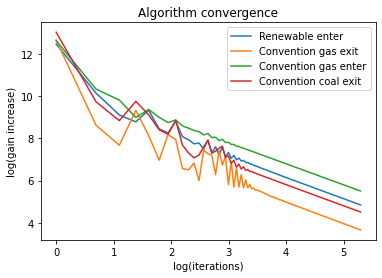

In [5]:
# Algorithm convergence illustration
logIter = np.log(range(1,Niter,1))

plt.figure()
plt.plot(logIter, np.log(save_ob_R[1:]), label = "Renewable enter")
plt.plot(logIter, np.log(save_ob_G[1:]), label = "Convention gas exit")
plt.plot(logIter, np.log(save_ob_G_enter[1:]), label = "Convention gas enter")
plt.plot(logIter, np.log(save_ob_C[1:]), label = "Convention coal exit")
plt.title("Algorithm convergence")
plt.xlabel('log(iterations)')
plt.ylabel('log(gain increase)')
plt.legend()
plt.show()

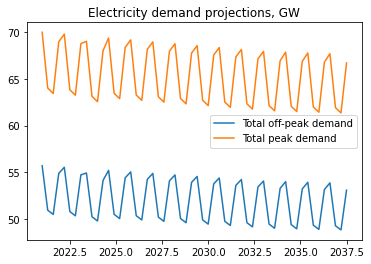

In [6]:
# Electricity demand projections, GW
plt.figure()
plt.plot(2021+T[:56],opdemand[:56],label='Total off-peak demand')
plt.plot(2021+T[:56],pdemand[:56],label='Total peak demand')
plt.title('Electricity demand projections, GW')
plt.legend()
plt.show()

Text(0.5, 0.92, 'Renewable')

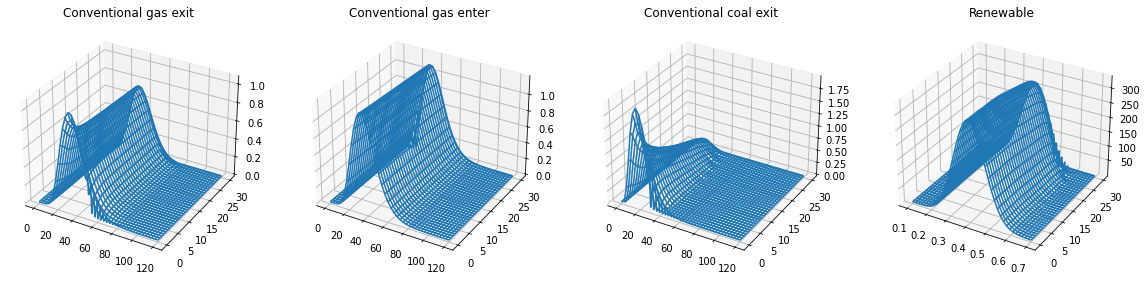

In [7]:
from mpl_toolkits.mplot3d import Axes3D # This import has side effects required for the kwarg projection='3d' in the call to fig.add_subplot

fig = plt.figure(figsize=(20,10))


newOm = np.reshape(Omega,(Nt,NC))
ax = fig.add_subplot(141, projection='3d')
XX, YY = np.meshgrid(C, T)
ax.plot_wireframe(XX, YY, newOm)
plt.title('Conventional gas exit')

newLamb = np.reshape(Lambda,(Nt,NC))
ax = fig.add_subplot(142, projection='3d')
XX, YY = np.meshgrid(C, T)
ax.plot_wireframe(XX, YY, newLamb)
plt.title('Conventional gas enter')

newMu = np.reshape(Mu,(Nt,NC))
ax = fig.add_subplot(143, projection='3d')
XX, YY = np.meshgrid(C, T)
ax.plot_wireframe(XX, YY, newMu)
plt.title('Conventional coal exit')

newEta = np.reshape(Eta,(Nt,NS))
XX, YY = np.meshgrid(S, T)
ax2 = fig.add_subplot(144, projection='3d')
ax2.plot_wireframe(XX, YY, newEta)
plt.title('Renewable')

Text(0.5, 1.0, 'Renewable')

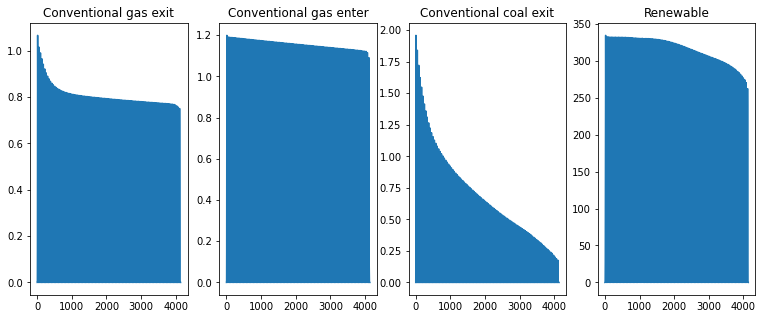

In [8]:
plt.figure(figsize=(13,5))

plt.subplot(1,4,1)
plt.plot(Omega)
plt.title('Conventional gas exit')

plt.subplot(1,4,2)
plt.plot(Lambda)
plt.title('Conventional gas enter')

plt.subplot(1,4,3)
plt.plot(Mu)
plt.title('Conventional coal exit')

plt.subplot(1,4,4)
plt.plot(Eta)
plt.title('Renewable')

Text(0.5, 1.0, 'Renewable')

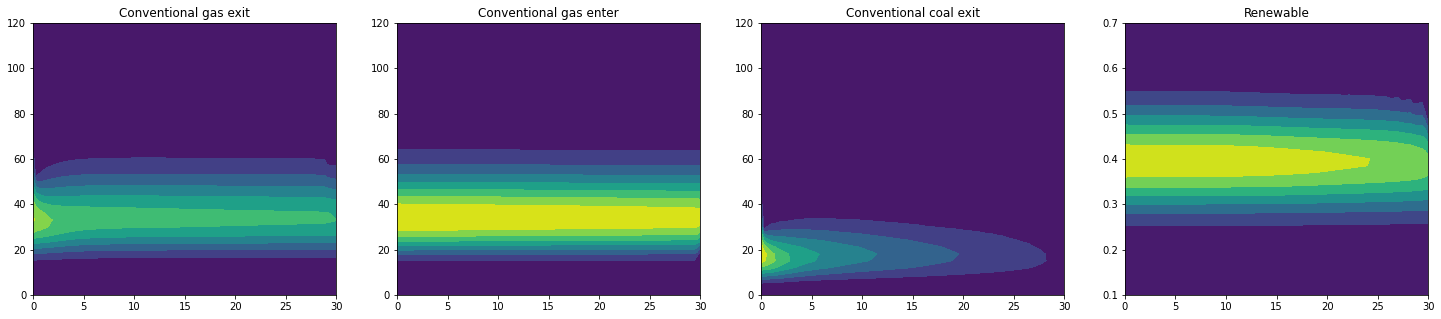

In [9]:
plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
XX, YY = np.meshgrid(C, T)
plt.contourf(YY, XX, newOm)
plt.title('Conventional gas exit')

plt.subplot(1,4,2)
XX, YY = np.meshgrid(C, T)
plt.contourf(YY, XX, newLamb)
plt.title('Conventional gas enter')

plt.subplot(1,4,3)
XX, YY = np.meshgrid(C, T)
plt.contourf(YY, XX, newMu)
plt.title('Conventional coal exit')

plt.subplot(1,4,4)
XX, YY = np.meshgrid(S, T)
plt.contourf(YY, XX, newEta)
plt.title('Renewable')

<ipython-input-10-25eb58102382>:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('231')
<ipython-input-10-25eb58102382>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('232')
<ipython-input-10-25eb58102382>:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('233')
<ipython-input-10-25eb58102382>:27: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('234')
<ipython-input-10-25eb58102382>:33: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is

Text(0.5, 1.0, 'Conventional installed capacity')

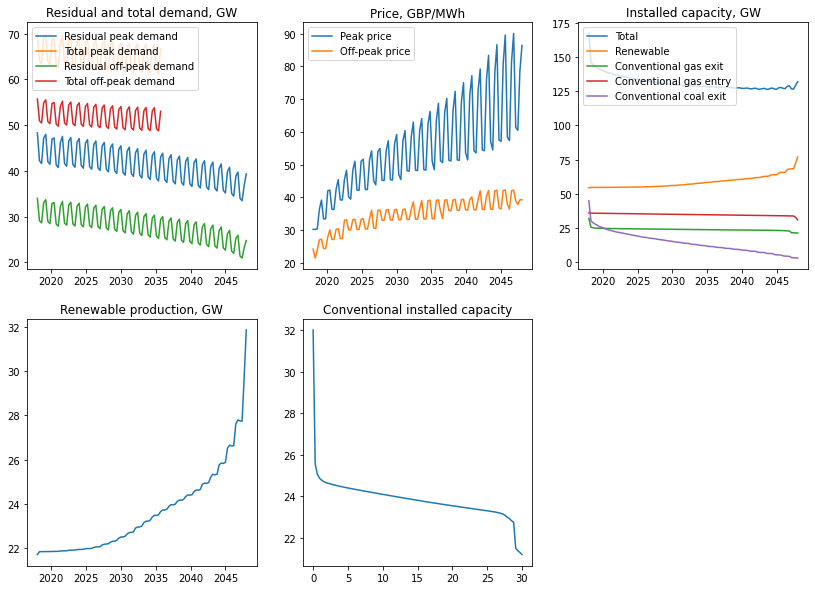

In [10]:
plt.figure(figsize=(14,10))

plt.subplot('231')
plt.plot(2018+T,RRp[:,Niter-1],label='Residual peak demand')
plt.plot(2018+T[:60],pdemand[:60],label='Total peak demand')
plt.plot(2018+T,RRop[:,Niter-1],label='Residual off-peak demand')
plt.plot(2018+T[:60],opdemand[:60],label='Total off-peak demand')
plt.title('Residual and total demand, GW')
plt.legend(loc=2)

plt.subplot('232')
plt.plot(2018+T,prphist[:,Niter-1],label='Peak price')
plt.plot(2018+T,prophist[:,Niter-1],label='Off-peak price')
plt.legend(loc=2)
plt.title('Price, GBP/MWh')

plt.subplot('233')
renhist = np.ones(penhist.shape)*np.sum(BarEta)*dS-penhist
plt.plot(2018+T,renhist[:,Niter-1]+g_exit_hist[:,Niter-1]+g_enter_hist[:,Niter-1]+c_hist[:,Niter-1],label='Total')
plt.plot(2018+T,renhist[:,Niter-1],label='Renewable')
plt.plot(2018+T,g_exit_hist[:,Niter-1],label='Conventional gas exit')
plt.plot(2018+T,g_enter_hist[:,Niter-1],label='Conventional gas entry')
plt.plot(2018+T,c_hist[:,Niter-1],label='Conventional coal exit')
plt.legend(loc=2)
plt.title('Installed capacity, GW')

plt.subplot('234')
plt.plot(2018+T,np.sum(BarEta*S)*dS-renpen[:,Niter-1])
plt.title('Renewable production, GW')

#plt.savefig('industry_dynamics_peak_offpeak_baseline.pdf',format='pdf')

plt.subplot('235')
plt.plot(T,g_exit_hist[:,-1])
plt.title('Conventional installed capacity')

In [11]:
print(prphist[:,Niter-1])

[30.25315744 30.22850811 30.39423649 36.37671035 39.1949419  33.44436262
 33.48759201 42.00597282 42.26643282 36.33158239 36.33979052 42.47094641
 45.42415467 39.25175206 39.22154167 45.47831945 48.27195729 40.11499496
 39.47075012 48.27686586 51.07740891 42.21283726 42.15364706 51.04344277
 51.64165289 42.44696681 42.38039974 51.38684715 54.21928882 45.06397331
 43.82712123 54.01612819 54.93164705 45.22716431 45.13920997 54.34991965
 57.27991743 45.39886928 45.29795646 56.39532761 59.2085556  46.98510103
 45.4419601  57.29660877 60.38104589 48.13023095 48.00296003 58.61457385
 62.9829892  48.32698975 48.17693705 60.32474843 64.04442632 48.47441266
 48.32085015 62.46774818 66.27432    51.0272499  48.46256699 63.42140807
 68.72237727 51.18383462 50.63630284 65.97432696 70.21071104 51.32489452
 51.12269274 66.60717274 72.34918497 51.45965292 51.29133328 69.21553036
 75.00702047 53.62909983 51.43423416 71.32000046 77.13256673 54.2288971
 53.58137394 72.74278763 79.18084751 54.49889821 54.

In [12]:
print(prophist[:,Niter-1])

[24.22552417 21.49679667 24.03981157 27.06204087 27.26762514 24.39303904
 24.43835411 27.86274125 30.09356845 27.14944704 27.17114719 30.25096612
 30.46509264 27.45317126 27.45363359 33.00886227 33.15934058 30.10852031
 30.09402379 33.19823958 33.33877014 30.26147627 30.23961516 33.35636774
 33.49239193 30.3937646  30.36718471 33.49249627 36.08333207 30.63113461
 30.4694815  36.05585272 36.18819663 33.04750813 33.00979428 36.15645824
 36.29007817 33.13375844 33.09075    36.24270728 36.37501392 33.20777752
 33.16402251 36.32729583 36.46915099 33.28409697 33.23958108 36.39994997
 38.64411033 33.35339695 33.30681444 36.48475695 39.08180043 33.42028836
 33.37105983 39.00867664 39.16012937 33.48261347 33.43390068 39.08890993
 39.23937455 35.747261   33.49141577 39.16075313 39.30989957 36.05377886
 35.84876653 39.22658553 39.37804006 36.11111463 36.05602033 39.30028144
 39.44781693 36.16984855 36.11633177 39.36872635 40.13481781 36.24051899
 36.18345107 39.42846796 42.02000611 36.33042138 36

In [13]:
print(g_enter_hist[:,Niter-1])

[35.99985522 35.81153703 35.76664226 35.74409445 35.72206639 35.70031735
 35.67873264 35.65725344 35.63584746 35.61449582 35.5931868  35.57191276
 35.55066848 35.52945024 35.50825534 35.4870817  35.46592775 35.44479225
 35.42367419 35.40257278 35.38148735 35.36041737 35.33936239 35.31832202
 35.29729595 35.27628391 35.25528568 35.23430105 35.21332987 35.192372
 35.1714273  35.15049568 35.12957704 35.1086713  35.08777839 35.06689825
 35.04603083 35.02517607 35.00433395 34.98350442 34.96268744 34.94188299
 34.92109105 34.90031158 34.87954457 34.85879    34.83804784 34.81731809
 34.79660072 34.77589573 34.75520309 34.7345228  34.71385485 34.69319922
 34.6725559  34.65192488 34.63130616 34.61069971 34.59010555 34.56952365
 34.548954   34.5283966  34.50785144 34.48731851 34.4667978  34.44628931
 34.42579303 34.40530894 34.38483705 34.36437734 34.34392981 34.32349444
 34.30307124 34.28266019 34.26226128 34.24187452 34.22149989 34.20113738
 34.18078698 34.1604487  34.14012252 34.11980844 34.0

In [14]:
print(g_exit_hist[:,Niter-1])

[31.99987131 25.55640093 25.0748937  24.88355826 24.78086361 24.70946441
 24.66885099 24.63486712 24.6044738  24.57341649 24.54905227 24.52611945
 24.50272769 24.47804098 24.4562877  24.43647637 24.41666953 24.39546487
 24.37620375 24.35817843 24.33813946 24.31819975 24.29963482 24.28208559
 24.26319138 24.24378118 24.22616597 24.2089048  24.19169426 24.17219841
 24.15437752 24.13702596 24.11983348 24.10061251 24.08417533 24.06763882
 24.04943616 24.03197368 24.01496864 23.99814422 23.98145014 23.96288531
 23.94559166 23.92862089 23.91184714 23.89322717 23.8773328  23.86123556
 23.84513537 23.82517447 23.80932403 23.79411776 23.77868    23.75798723
 23.74229977 23.72722467 23.71191564 23.69410634 23.6788797  23.6640757
 23.6490891  23.63226714 23.61735183 23.60267916 23.58792062 23.57180205
 23.55701534 23.54248555 23.52787379 23.51274738 23.49819717 23.48378887
 23.46932346 23.45469435 23.44027621 23.42583859 23.41140259 23.39712936
 23.38259869 23.36815612 23.35378539 23.33945146 23.

In [15]:
print(c_hist[:,Niter-1])

[44.90047032 30.18658873 28.77498305 27.82299272 26.94787409 25.99260123
 25.50157216 24.93445917 24.31975294 23.6687677  23.30707765 22.92727222
 22.5173626  22.07292594 21.81348612 21.53239238 21.24170943 20.88873127
 20.59702431 20.31388134 20.01959774 19.68910707 19.39854358 19.11972304
 18.83852965 18.5174176  18.24460467 18.08942761 17.90735877 17.5406636
 17.36628423 17.20262778 17.01973377 16.65621011 16.3908617  16.25675398
 16.04250618 15.72441862 15.48377907 15.35967543 15.12059147 14.80627947
 14.58910124 14.47137301 14.3256484  14.01044498 13.79829429 13.69155589
 13.56151246 13.09913898 12.93519923 12.84178097 12.7271621  12.31745844
 12.16148951 12.07627417 11.96958594 11.53549878 11.4016049  11.32427634
 11.22686257 10.82860881 10.70506298 10.63382632 10.54357998 10.16447823
 10.04758979  9.9810576   9.89861381  9.53521805  9.33429884  9.28368825
  9.21472516  8.86350202  8.68562856  8.61615237  8.55912329  8.07246862
  7.9505945   7.89578341  7.84729436  7.16178556  7.

In [16]:
print(renhist[:,Niter-1])

[54.29895728 54.62287188 54.62487313 54.62696739 54.62954555 54.63154599
 54.63387568 54.63968543 54.64596082 54.64838542 54.65413797 54.68402316
 54.6966456  54.70087348 54.7093604  54.75636267 54.77465767 54.77866953
 54.78722391 54.83279053 54.85060061 54.85488804 54.86642281 54.91833453
 54.94057496 54.94529305 54.96089496 55.04037678 55.08390274 55.09522293
 55.11874559 55.25068804 55.31950475 55.34514803 55.38438793 55.51352417
 55.59302408 55.62202102 55.70084295 55.90059028 55.99829718 56.02401766
 56.1038388  56.30991406 56.43776218 56.48529778 56.55318655 56.88237403
 56.99075289 57.03484642 57.14022731 57.43981268 57.59280259 57.63197608
 57.74600332 58.0312541  58.21177334 58.24698158 58.34683525 58.62946139
 58.80608429 58.83903463 58.94485722 59.21308922 59.38674358 59.4186837
 59.51744808 59.78528331 59.92379359 59.95715952 60.0619599  60.32885509
 60.49599522 60.5277684  60.6001989  60.88009095 61.05310444 61.08447402
 61.18459931 61.63173498 61.78113857 61.80948643 61.